# Import xlsx file and clean up raw data

Using pandas:

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

# import raw data
df = pd.read_excel('ltbp-data-fusion-modified.xlsx', sheetname='Main', 
              header=2,
              index_col=280)

# remove first row nans
df = df.ix[1:]

## Forward fill to correct NaNs from merged or missing cells

This operation should be column name specific and used only on columns where Span1 of each structure is guarenteed to have a value. 

In [2]:
cols = ['#', 'State', 'Structure Number', 'Structure Name', 'Imperial or Metric']

for col in cols:
    df[col]=pd.Series(df[col].fillna(method='ffill'))

df.head()

,#,State,Structure Number,Span,Structure Name,Protocol Name,Imperial or Metric,Data Collected by,Date of Data Collection,Duration of Documentation (hr),...,Wing wall number,Wing wall dimensions,Wing wall footing dimensions,Type of Wing wall Foundation,Friction or bearing pile.2,Type of Pile,Pile Dimensions.1,Number of Straight pile rows,Number of Battered pile rows,Comments.11
1.0,1.0,AL,013533,1.0,I 65 over SARDIS ROAD,NaN,Imperial,Davood Mesbah,2016-08-01 00:00:00,6,...,"A, B","L=5'-0""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,1.0,AL,013533,2.0,I 65 over SARDIS ROAD,NaN,Imperial,NaN,NaN,NaN,...,"C, D","L=5'-0""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.0,1.0,AL,013533,3.0,I 65 over SARDIS ROAD,NaN,Imperial,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.0,2.0,AL,012296,1.0,I 459 over SULPHUR SPRINGS RD,NaN,Imperial,Hyungjoo Choi,2016-08-01 00:00:00,6.0,...,"A,B",L=7',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5.0,2.0,AL,012296,2.0,I 459 over SULPHUR SPRINGS RD,NaN,Imperial,NaN,NaN,NaN,...,"C,D",L=7',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Convert unit columns

In [3]:
def parse_length(val,disp=False):
    """Converts strings to floats and returns values in decimal feet"""
    
    if isinstance(val,str) is not True:
        print('Not a string, exiting')
        return 
    
    # strip leading and trailing whitespace
    val = val.strip()
    
    # find feet units and convert str->float
    ft_ = val.find("'")
    if ft_ != -1:
        ft = float(val[0:ft_])
    else:
        # no feet give, assign zero
        ft = 0
    
    # find inch units and convert str->float->feet
    in_start = val.find("-")
    # remove trailing whitespace before finding whitespace between int and fract
    in_fract_start = val.rfind(" ") 
    in_fract = val.find("/")
    in_end = val.find("\"")
    in_dec = val.find('.')
    
    # error screen
    if in_start == -1: 
        if ft_ == -1:
            # no feet given so start at beginning of string
            in_start = 0
        else:
            # feet were given but no '-' delimiter found. assume there is a space deliminiter
            in_start = val.find(" ")
            # if no whitespace found, use the "'" as a delim and advance +1
            if in_start == -1:
                in_start = ft_+1
                
    else:
        # '-' found, advance past or else we get a negative
        in_start = in_start+1
        
    if in_end == -1:
        # no inches found, assign zero total inches
        inches = 0
    else:
        if in_fract == -1:
            # no inch fraction given, check for decimal and convert indexed string to float
            if in_dec == -1:
                inches = float(val[in_start:in_end])
            else:
                inches = float(val[in_start:in_dec]) + float(val[in_dec:in_end])
        else:
            # fractional inches found, sum and convert
            inches = float(val[in_start:in_fract_start]) + (float(val[in_fract_start+1:in_fract]) / float(val[in_fract+1:in_end]))
    
    total_feet = ft+(inches/12)
    # optional display
    if disp==True:
        print('Input: {}\tFeet: {}\t Inches: {}\tTotal feet: {}'.format(val,ft,inches,total_feet))
    
    return total_feet

### Unit conversion benchmark

In [4]:
tests = ["7'", "7'-6\"", "6\"", "7'-6 1/8\"", "7'-6.125\"", "7' - 6\"", "10.5'",
         "7' - 6 1/8\"", "7' - 6.125\"", "7'- 6.125\"", "7'- 6 1/8\"", " 7' - 6 1/8\" ",
         "7' 6\"", "7'6\"", "7' 6 1/8\""]
breaks = ["7'-1/8\""]

for test in tests:
    parse_length(test,disp=True)

Input: 7'	Feet: 7.0	 Inches: 0	Total feet: 7.0
Input: 7'-6"	Feet: 7.0	 Inches: 6.0	Total feet: 7.5
Input: 6"	Feet: 0	 Inches: 6.0	Total feet: 0.5
Input: 7'-6 1/8"	Feet: 7.0	 Inches: 6.125	Total feet: 7.510416666666667
Input: 7'-6.125"	Feet: 7.0	 Inches: 6.125	Total feet: 7.510416666666667
Input: 7' - 6"	Feet: 7.0	 Inches: 6.0	Total feet: 7.5
Input: 10.5'	Feet: 10.5	 Inches: 0	Total feet: 10.5
Input: 7' - 6 1/8"	Feet: 7.0	 Inches: 6.125	Total feet: 7.510416666666667
Input: 7' - 6.125"	Feet: 7.0	 Inches: 6.125	Total feet: 7.510416666666667
Input: 7'- 6.125"	Feet: 7.0	 Inches: 6.125	Total feet: 7.510416666666667
Input: 7'- 6 1/8"	Feet: 7.0	 Inches: 6.125	Total feet: 7.510416666666667
Input: 7' - 6 1/8"	Feet: 7.0	 Inches: 6.125	Total feet: 7.510416666666667
Input: 7' 6"	Feet: 7.0	 Inches: 6.0	Total feet: 7.5
Input: 7'6"	Feet: 7.0	 Inches: 6.0	Total feet: 7.5
Input: 7' 6 1/8"	Feet: 7.0	 Inches: 6.125	Total feet: 7.510416666666667


# Girder Spacing

In [5]:
df['Girder Spacing'].dtype

df['Girder Spacing'] = df['Girder Spacing'].astype('str')

girder_spacing = df['Girder Spacing'].apply(lambda x:parse_length(x,disp=True))

Input: 7'-0"	Feet: 7.0	 Inches: 0.0	Total feet: 7.0
Input: 7'-0"	Feet: 7.0	 Inches: 0.0	Total feet: 7.0
Input: 7'-0"	Feet: 7.0	 Inches: 0.0	Total feet: 7.0
Input: 7'-1"	Feet: 7.0	 Inches: 1.0	Total feet: 7.083333333333333
Input: 7'-1"	Feet: 7.0	 Inches: 1.0	Total feet: 7.083333333333333
Input: 7'-1"	Feet: 7.0	 Inches: 1.0	Total feet: 7.083333333333333
Input: 7'-6"	Feet: 7.0	 Inches: 6.0	Total feet: 7.5
Input: 7'-6"	Feet: 7.0	 Inches: 6.0	Total feet: 7.5
Input: 7'-6"	Feet: 7.0	 Inches: 6.0	Total feet: 7.5
Input: 7'-6"	Feet: 7.0	 Inches: 6.0	Total feet: 7.5
Input: 7'-0"	Feet: 7.0	 Inches: 0.0	Total feet: 7.0
Input: 7'-0"	Feet: 7.0	 Inches: 0.0	Total feet: 7.0
Input: 7'-0"	Feet: 7.0	 Inches: 0.0	Total feet: 7.0
Input: 7'-0"	Feet: 7.0	 Inches: 0.0	Total feet: 7.0
Input: 7'-0"	Feet: 7.0	 Inches: 0.0	Total feet: 7.0
Input: 7'-0"	Feet: 7.0	 Inches: 0.0	Total feet: 7.0
Input: 7'-0"	Feet: 7.0	 Inches: 0.0	Total feet: 7.0
Input: 7'-0"	Feet: 7.0	 Inches: 0.0	Total feet: 7.0
Input: 7'-0"	Feet: 7.0

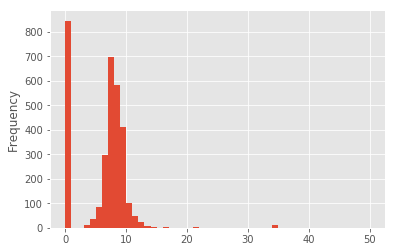

In [6]:
girder_spacing.plot.hist(bins=50)
plt.show()

In [7]:
gs = pd.concat([df['#'], df['State'], df['Structure Number'], girder_spacing], axis=1)
gs.describe()

,#,Girder Spacing
count,3167.000000,3167.000000
mean,21.639091,5.985933
std,15.479007,4.180311
min,1.000000,0.000000
25%,9.000000,0.000000
50%,18.000000,7.333333
75%,32.500000,8.583333
max,62.000000,50.000000
